In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import FeatureUnion
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier, Perceptron
from sklearn.compose import ColumnTransformer

#Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report

# Model evaluation und visualisation
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve

# Hyperparameter optimisation
from sklearn.model_selection import GridSearchCV


df = pd.read_csv("hotel.csv")

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 36 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

## Checking for data type

Above can be summarised as three types of data:
1. Booking Information
2. Customer Information
3. Room Information

## Questions we may be able to answer:

1.What are the key factors influencing hotel booking cancellations?

Booking information data:
- lead time & cancellation
- the number of special requests & cancellation
- deposit type & cancellation (maybe a correlation between non-refundable deposits and lower cancellation rates)
- Bookings & cancellations by month: What patterns can we see related to cancellation in different periods?
- distribution_channel & cancellation

Customer Information data: customer profile(are customers of certain types more likely to cancel their booking?)
- number of people booked & cancellations:  Single occupancy/Double occupancy/Family occupancy
- required_car_parking_spaces & cancellation
- Customer_booking_history & cancellation
- distribution_channel & cancellation
- length of stay & cancellation

Room information data:
- price per night & cancellations
- room type & cancellation 
- room_chaged & cancellation

2.In terms of the hotel type, a comparison between the results of Resort and City Hotel 

3.How can we predict whether a booking will be cancelled, based on the given data?


# 1 Data preprocessing

## 1.1 Checking for Missing data 

In [3]:
missing = df.isnull().sum(axis=0)
missing[missing!=0]

children         4
country        488
agent        16340
company     112593
dtype: int64

In [4]:
df.drop(['company'], axis=1, inplace=True)
df.children.fillna(df.children.mode()[0],inplace=True)
df.country.fillna(df.country.mode()[0],inplace=True)
df['agent'] = df['agent'].notna().astype(int)

In [5]:
# checking for data type
df['children']=df['children'].astype('int64')  

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 35 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119390 non-null  int64  
 11  babies                          119390 non-null  int64  
 12  meal            

## 1.2 Checking for Duplicate Data

In [7]:
df.duplicated().sum()

0

## 1.3 Checking for Abnormal Data

In [8]:
zero_guest=df[df[['adults', 'children', 'babies']].sum(axis=1) == 0]  
df.drop(zero_guest.index, inplace=True)

zero_days = df[df[['stays_in_weekend_nights','stays_in_week_nights']].sum(axis=1) == 0]
df.drop(zero_days.index, inplace=True)

df.meal.replace("Undefined", "SC", inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118565 entries, 2 to 119389
Data columns (total 35 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           118565 non-null  object 
 1   is_canceled                     118565 non-null  int64  
 2   lead_time                       118565 non-null  int64  
 3   arrival_date_year               118565 non-null  int64  
 4   arrival_date_month              118565 non-null  object 
 5   arrival_date_week_number        118565 non-null  int64  
 6   arrival_date_day_of_month       118565 non-null  int64  
 7   stays_in_weekend_nights         118565 non-null  int64  
 8   stays_in_week_nights            118565 non-null  int64  
 9   adults                          118565 non-null  int64  
 10  children                        118565 non-null  int64  
 11  babies                          118565 non-null  int64  
 12  meal            

## 1.4 Adding columns

In [10]:
#add total family size column and total stay column
df['total_family_size']=df['adults']+df['children']+df['babies']
df['total_stay']=df['stays_in_weekend_nights']+df['stays_in_week_nights']
df['roomtype_change'] = np.where(df['reserved_room_type'] != df['assigned_room_type'], 1, 0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118565 entries, 2 to 119389
Data columns (total 38 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           118565 non-null  object 
 1   is_canceled                     118565 non-null  int64  
 2   lead_time                       118565 non-null  int64  
 3   arrival_date_year               118565 non-null  int64  
 4   arrival_date_month              118565 non-null  object 
 5   arrival_date_week_number        118565 non-null  int64  
 6   arrival_date_day_of_month       118565 non-null  int64  
 7   stays_in_weekend_nights         118565 non-null  int64  
 8   stays_in_week_nights            118565 non-null  int64  
 9   adults                          118565 non-null  int64  
 10  children                        118565 non-null  int64  
 11  babies                          118565 non-null  int64  
 12  meal            

查看不同国家订单取消率, 选取预定数前15的国家/地区

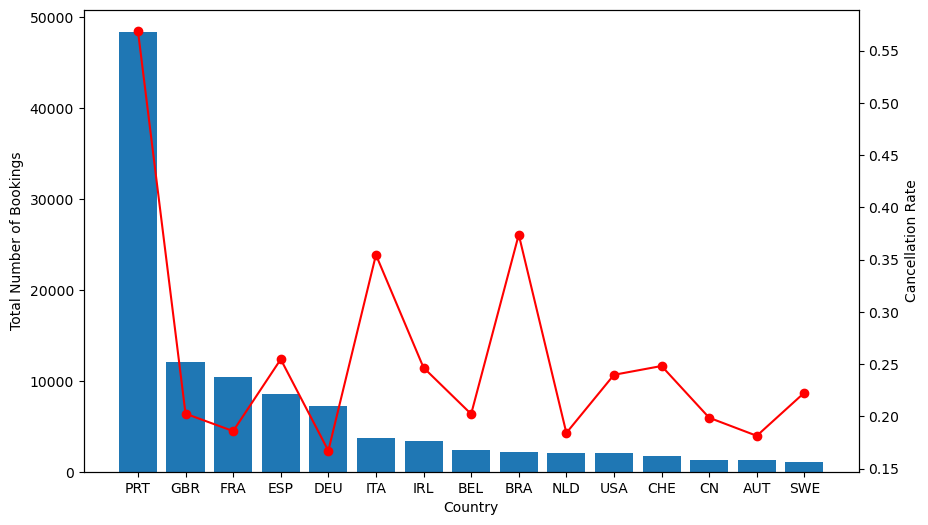

In [11]:
top_15_countries = df.groupby('country').size().sort_values(ascending=False).head(15).index.tolist()

# Compute the proportion of bookings that belong to the top 15 countries
proportion_top_15 = df[df.country.isin(top_15_countries)].shape[0] / df.shape[0]

fig, bookings_axis = plt.subplots(figsize=(10, 6))

# Create a second y-axis for the same x-axis
cancellation_rate_axis = bookings_axis.twinx()

plt.xticks(range(15), top_15_countries)

# Create a bar plot on the first y-axis showing the total number of bookings for each of the top 15 countries
bookings_per_country = df[df.country.isin(top_15_countries)].groupby('country').size().sort_values(ascending=False)
bookings_axis.bar(range(15), bookings_per_country)

bookings_axis.set_xlabel('Country')
bookings_axis.set_ylabel('Total Number of Bookings')

# Create a line plot on the second y-axis showing the cancellation rate for each of the top 15 countries
cancellation_rate_per_country = df[df.country.isin(top_15_countries)].groupby('country')['is_canceled'].mean().loc[top_15_countries]
cancellation_rate_axis.plot(range(15), cancellation_rate_per_country, 'ro-')

cancellation_rate_axis.set_ylabel('Cancellation Rate')

# Display the plot
plt.show()

([<matplotlib.axis.XTick at 0x15969f880>,
 [Text(0, 0, 'New Guest'), Text(1, 0, 'Repeated Guest')])

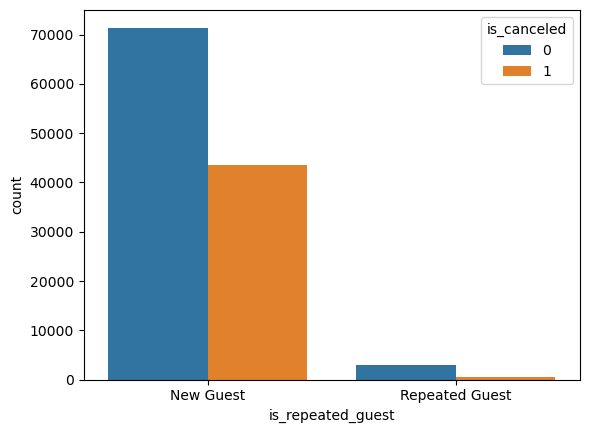

In [12]:

tick_label = ['New Guest', 'Repeated Guest']
sns.countplot(x='is_repeated_guest', hue='is_canceled', data=df)
plt.xticks([0, 1], tick_label)

Text(0.5, 0, 'Previous Un-Cancellations')

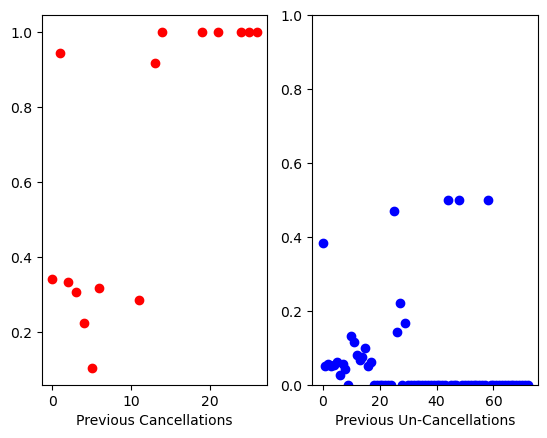

In [13]:
plt.subplot(121)
plt.plot(df.groupby('previous_cancellations')['is_canceled'].mean(),
         'ro')
plt.xlabel('Previous Cancellations')

plt.subplot(122)
plt.plot(df.groupby('previous_bookings_not_canceled')['is_canceled'].mean(),
         'bo')
plt.ylim(0, 1)
plt.xlabel('Previous Un-Cancellations')


## insights

The majority of bookings are made by new guests. 
However, their probability of canceling a reservation is significantly higher than that of repeat guests. 
This suggests that familiarity with the hotel's services may enhance guests' commitment to their bookings.

There's a strong correlation between previous booking cancellations and the likelihood of canceling current bookings.
Notably, guests who have canceled bookings more than 15 times have a near-certain cancellation rate. 
These guests could potentially be identified as "high-risk" to the hotel's reservation system.
Guests who have previously booked and fulfilled their stays display more reliable booking behaviors. 
Particularly, those who have made more than 20 bookings have an exceptionally low cancellation rate. 
These loyal guests represent a consistent and dependable customer base for the hotel.




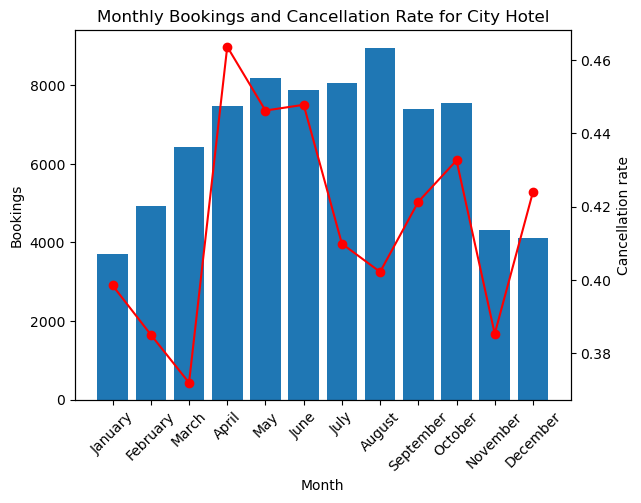

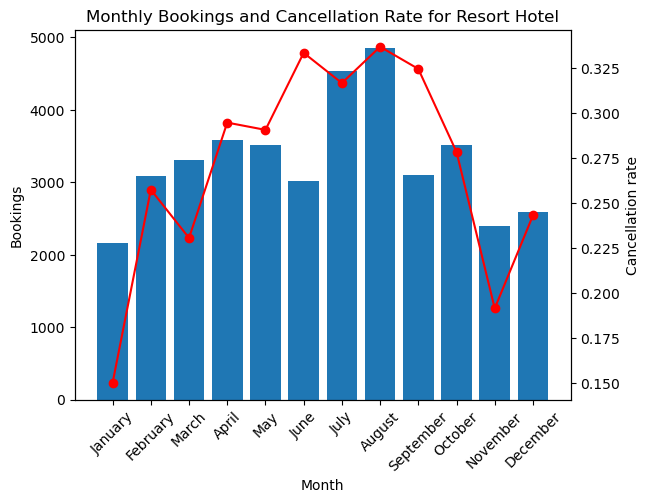

In [14]:
ordered_months = [
    "January", "February", "March", "April", "May", "June", "July", "August",
    "September", "October", "November", "December"
]

for hotel in ['City Hotel', 'Resort Hotel']:
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    df_hotel = df[df.hotel == hotel]
    monthly = df_hotel.groupby('arrival_date_month').size()

    ax1.bar(np.arange(12), monthly[ordered_months])
    ax2.plot(np.arange(12), df_hotel.groupby('arrival_date_month')['is_canceled'].mean()[ordered_months].values, 'ro-')
    
    ax1.set_xlabel('Month')
    ax1.set_ylabel('Bookings')
    ax1.set_xticks(np.arange(12))
    ax1.set_xticklabels(ordered_months, rotation=45)
    ax1.set_title(f'Monthly Bookings and Cancellation Rate for {hotel}')  
    
    ax2.set_ylabel('Cancellation rate')

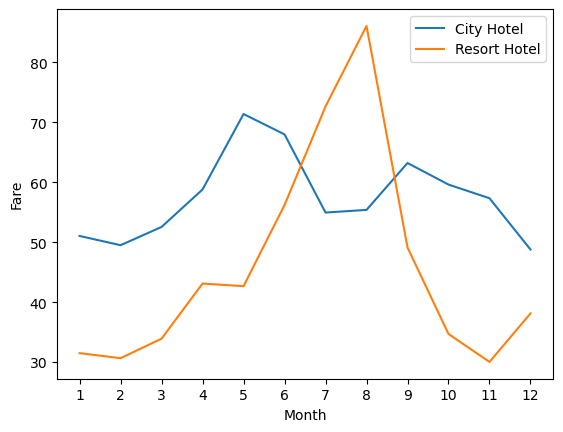

In [15]:
df['adr_per_person'] = df['adr'] / (df['adults'] + df['children'])
plt.plot(df[df.hotel == 'City Hotel'].groupby('arrival_date_month')
         ['adr_per_person'].mean()[ordered_months],
         label='City Hotel')
plt.plot(df[df.hotel == 'Resort Hotel'].groupby('arrival_date_month')
         ['adr_per_person'].mean()[ordered_months],
         label='Resort Hotel')
plt.xlabel('Month')
plt.ylabel('Fare')
plt.xticks(np.arange(12), range(1, 13))
plt.legend()

Text(0, 0.5, 'Rate')

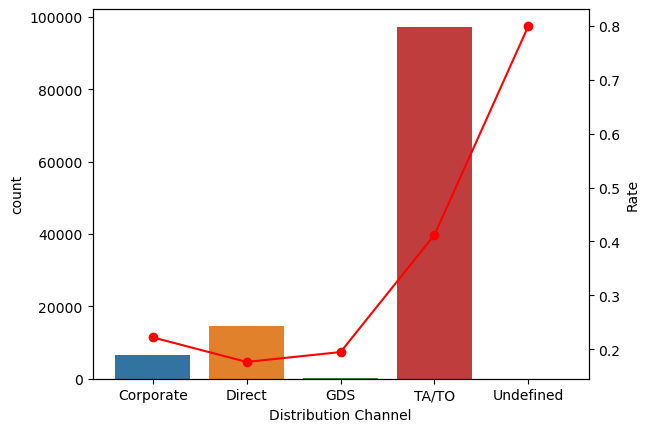

In [16]:
fig,ax1 = plt.subplots()
ax2 = ax1.twinx()
sns.countplot(
    x=df['distribution_channel'],
    order =df.groupby('distribution_channel')['is_canceled'].mean().index,ax=ax1)

ax1.set_xlabel('Distribution Channel')
ax2.plot(df.groupby('distribution_channel')['is_canceled'].mean(), 'ro-')
ax2.set_ylabel('Rate')

## Lead_time & Cancellation

Text(0, 0.5, 'Cancellation rate')

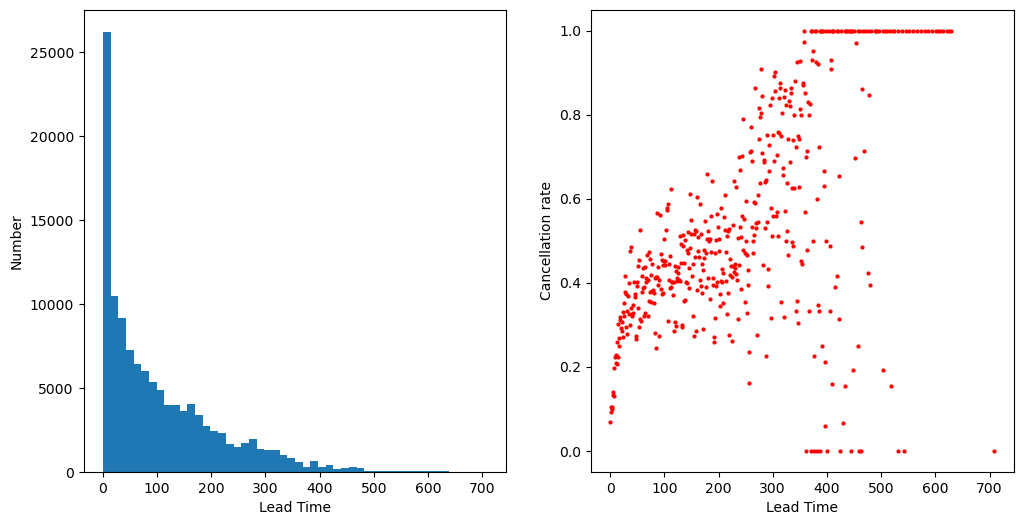

In [17]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.hist(df['lead_time'], bins=50)
plt.xlabel('Lead Time')
plt.ylabel('Number')

plt.subplot(122)
plt.plot(df.groupby('lead_time')['is_canceled'].mean().index,
         df.groupby('lead_time')['is_canceled'].mean(),
         'ro',
         markersize=2)
plt.xlabel('Lead Time')
plt.ylabel('Cancellation rate')

# 2 Model Stage

## Test-Train split

In [18]:
# Split the data
y = df['is_canceled'].copy()
X = df.drop(['is_canceled'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

In [19]:
print(X.shape)
print(y.shape)

(118565, 38)
(118565,)


## Pre-process data

In [20]:
# Numerical columns
num_cols = ['lead_time', 'arrival_date_week_number', 'arrival_date_day_of_month',
            'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 
            'required_car_parking_spaces', 'total_of_special_requests', 
            'adr_per_person', 'total_family_size', 'total_stay']

# Categorical columns for one-hot encoding, no feature is suitable for ordinal encoding
cat_cols = ['hotel', 'arrival_date_month', 'market_segment', 'distribution_channel', 
            'deposit_type', 'customer_type', 'roomtype_change']

In [21]:
# Define the pipelines
num_pipeline = Pipeline(steps=[('std_scaler', StandardScaler())])
cat_pipeline = Pipeline(steps=[('one_hot_encoder', OneHotEncoder(drop='first'))])

# Combine pipelines in a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_cols),
        ('cat', cat_pipeline, cat_cols)
    ])

# Full pipeline
full_pipeline = Pipeline(steps=[ ('preprocessor', preprocessor)])

In [22]:
# Fit and transform the training data
X_train_prepared = full_pipeline.fit_transform(X_train)

In [23]:
print(X_train_prepared.shape)
print(y_train.shape)

(82995, 40)
(82995,)


# Evaluate models

## Logistic Regression

In [24]:
lr=LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_prepared,y_train)

# Predict on the training data
train_preds = lr.predict(X_train_prepared)

In [25]:
coefs=lr.coef_[0]                      # coeficient from the classifier
for (a,c) in zip(num_cols,coefs):  
    # just the numeric; categorical needs to unpack the one hot encoding
    print('%8s: %5.4f' % (a,c) )

lead_time: 0.3951
arrival_date_week_number: -0.7577
arrival_date_day_of_month: 0.0771
is_repeated_guest: -0.0881
previous_cancellations: 2.2848
previous_bookings_not_canceled: -0.7471
required_car_parking_spaces: -6.6431
total_of_special_requests: -0.5714
adr_per_person: 0.1325
total_family_size: 0.2018
total_stay: 0.0721


In [26]:
# Perform cross-validation
scores = cross_val_score(lr, X_train_prepared, y_train, 
                         scoring="accuracy", cv=10)

# Function to display scores
def display_scores(scores):
    print('Mean:%5.4f'%scores.mean())
    print('Standard deviation:%5.4f'%scores.std())

# Display cross-validation scores
display_scores(scores)


Mean:0.8124
Standard deviation:0.0048


## Decision Tree

In [27]:
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train_prepared, y_train)

train_preds = tree.predict(X_train_prepared)

In [28]:
# Perform cross-validation and calculate RMSE scores
scores = cross_val_score(tree, X_train_prepared, y_train, 
                         scoring="accuracy", cv=10)

def display_scores(scores):
    print('Mean:%5.4f'%scores.mean())
    print('Standard deviation:%5.4f'%scores.std())


display_scores(scores)

Mean:0.8178
Standard deviation:0.0046


## Random Forest

In [29]:
forest = RandomForestClassifier(random_state=42)
forest.fit(X_train_prepared, y_train)

train_preds = forest.predict(X_train_prepared)


In [30]:
# Perform cross-validation
scores = cross_val_score(forest, X_train_prepared, y_train, 
                         scoring="accuracy", cv=10)

def display_scores(scores):
    print('Mean:%5.4f'%scores.mean())
    print('Standard deviation:%5.4f'%scores.std())


display_scores(scores)

Mean:0.8624
Standard deviation:0.0043


## Support Vector Machine

In [31]:
svm = SVC()
%time svm.fit(X_train_prepared, y_train)
train_preds = svm.predict(X_train_prepared)

CPU times: user 2min 57s, sys: 1.82 s, total: 2min 58s
Wall time: 2min 59s


In [32]:
%time svm_scores = cross_val_score(svm, X_train_prepared,y_train, scoring="accuracy", cv=5)

def display_scores(scores):
    print('Mean:%5.4f'%scores.mean())
    print('Standard deviation:%5.4f'%scores.std())
    
display_scores(svm_scores)

CPU times: user 11min 13s, sys: 7.44 s, total: 11min 21s
Wall time: 11min 22s
Mean:0.8199
Standard deviation:0.0034


## Hyper-parameter optimisation

In [33]:
param_grid = [
    {'n_estimators': [10, 50, 100], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

forest = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(forest, param_grid, cv=3,
                           scoring='accuracy', return_train_score=True)
%time grid_search.fit(X_train_prepared,y_train)

CPU times: user 1min 34s, sys: 1.41 s, total: 1min 35s
Wall time: 1min 36s


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [10, 50, 100]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='accuracy')

In [34]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

forest = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(forest, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train_prepared, y_train)

print(grid_search.best_params_)

best_forest = grid_search.best_estimator_

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


## Evaluation of the final model

In [35]:
final_model = grid_search.best_estimator_


X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_accuracy = accuracy_score(y_test, final_predictions)
print('Accuracy: %5.4f' % final_accuracy)

0.3696


## Confusion Matrix

Confusion Matrix:
[[20552  1765]
 [ 3093 10160]]
F1 Score: 0.8070537771069981
Accuracy: 0.8634242339049761
Precision: 0.8519916142557652
Recall: 0.7666188787444352
F1 Score: 0.8070537771069981


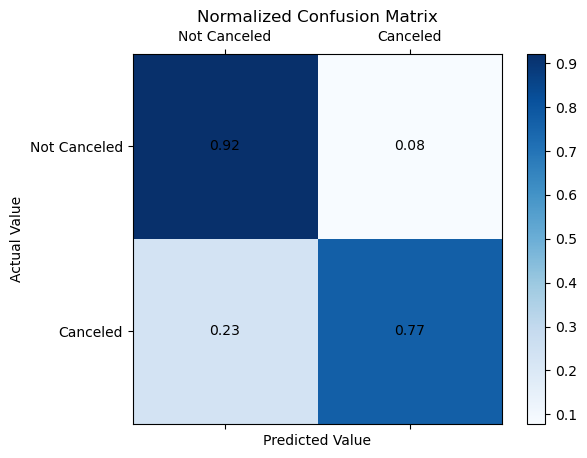

In [48]:
# Compute and print the confusion matrix
conf_mat = confusion_matrix(y_test, final_predictions)
print("Confusion Matrix:")
print(conf_mat)

# Re-import f1_score to solve type-error
from sklearn.metrics import f1_score

# calculate the f1_score again
f1 = f1_score(y_test, final_predictions)
print(f"F1 Score: {f1}")

# Compute and print accuracy, precision, recall, f1 score
accuracy = accuracy_score(y_test, final_predictions)
precision = precision_score(y_test, final_predictions)
recall = recall_score(y_test, final_predictions)
f1 = f1_score(y_test, final_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Plot the confusion matrix
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
labels = ['Not Canceled', 'Canceled']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat_normalized, cmap='Blues')
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')
plt.xticks([0, 1], labels)
plt.yticks([0, 1], labels)
fig.colorbar(cax)

# Add the actual numbers in the cells of the confusion matrix
for (i, j), z in np.ndenumerate(conf_mat_normalized):
    ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')

plt.show()

## ROC

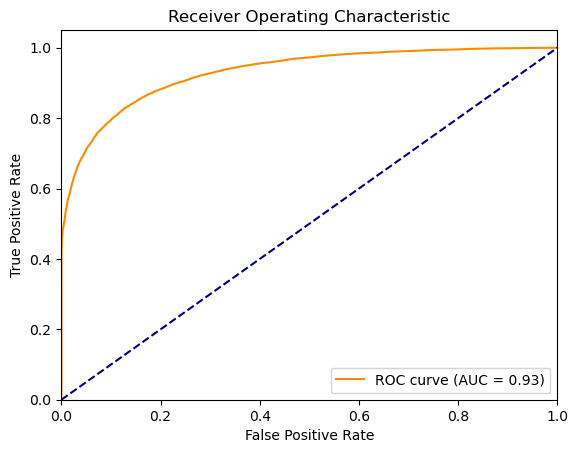

In [51]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities instead of binary predictions
y_scores = final_model.predict_proba(X_test_prepared)[:, 1]

# Compute false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Compute AUC score
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


## Correlation Analysis

In [52]:
# 相关系数
d = train.corr()
plt.subplots(figsize=(15, 15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
g = sns.heatmap(d,cmap=cmap, square=True, annot=True, fmt='0.2f')
plt.show()



NameError: name 'train' is not defined

In [ ]:

plt.figure(figsize=(20, 20))
sns.heatmap(d, annot=True)

In [ ]:
Type_Cancellations = round(df.groupby('hotel')['is_canceled'].value_counts(normalize=True)*100,2)
Type_Cancellations